<a href="https://colab.research.google.com/github/CuriousLady/Capstone_AIML_Group2/blob/main/GPT2_Tuning_Group2_Email_Subject_Line_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Capstone_Project/AESLC-master.zip -d /content/AESLC-master

Streaming output truncated to the last 5000 lines.
  inflating: /content/AESLC-master/AESLC-master/enron_subject_line/train/ring-a_inbox_9.subject  
  inflating: /content/AESLC-master/AESLC-master/enron_subject_line/train/ring-a_sent_34.subject  
  inflating: /content/AESLC-master/AESLC-master/enron_subject_line/train/ring-a_sent_41.subject  
  inflating: /content/AESLC-master/AESLC-master/enron_subject_line/train/ring-r_inbox_15.subject  
  inflating: /content/AESLC-master/AESLC-master/enron_subject_line/train/ring-r_inbox_18.subject  
  inflating: /content/AESLC-master/AESLC-master/enron_subject_line/train/ring-r_inbox_19.subject  
  inflating: /content/AESLC-master/AESLC-master/enron_subject_line/train/ring-r_inbox_26.subject  
  inflating: /content/AESLC-master/AESLC-master/enron_subject_line/train/ring-r_inbox_27.subject  
  inflating: /content/AESLC-master/AESLC-master/enron_subject_line/train/ring-r_inbox_28.subject  
  inflating: /content/AESLC-master/AESLC-master/enron_subject

In [ ]:
!pip uninstall transformers accelerate -y
!pip install transformers[torch] accelerate -U
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install nltk
!pip install rouge-score
%pip install evaluate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=cc26f52bb7bd2b9a877653e13c32603ec6333bcbd2f2a9ed782794c95e47f4b1
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

In [ ]:
import torch
import evaluate
from nltk.translate.bleu_score import corpus_bleu
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
from nltk.metrics.distance import edit_distance
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import sacrebleu
import math


In [ ]:
import re
import pandas as pd
import glob

# Create an empty DataFrame to store the results
df = pd.DataFrame(columns=['Body', 'Subject'])
folder_path = '/content/AESLC-master/AESLC-master/enron_subject_line/train/'
# Iterate over the files
file_paths = glob.glob(folder_path + '*.subject')  # Replace '/path/to/files/' with the actual path to your files
for file_path in file_paths:
    with open(file_path, 'r') as file:
        text = file.read()

        # Extract the text above the @subject marker
        body_text = re.search(r'^(.*?)(?=\s*@subject)', text, re.DOTALL).group(1).strip()

        subject = re.search(r'@subject\s+([^@]+)', text, re.DOTALL).group(1).strip()

        # Append the body text to the DataFrame
        df = pd.concat([df, pd.DataFrame({'Body': [body_text], 'Subject': [subject]})], ignore_index=True)


# Output the first few rows of the DataFrame
df.head()

,Body,Subject
0,Dad: The name I have is Dr. Vinberg.\nHe is a...,Facilitator
1,Hey Jeff - I'm still wondering if my last emai...,some mail
2,Thanks for dealing with Tana on these issues.\...,EnronOnline access to Australian Power products
3,Attached is the language we are proposing to D...,Draft Dynegy Release
4,"Sharon, Attached is an Excel file containing ...",Mariner Energy


In [ ]:
max_length = 512

df['Body'] = df['Body'].apply(lambda x: x[:max_length] if len(x) > max_length else x)

In [ ]:
df.head()

,Body,Subject
0,Dad: The name I have is Dr. Vinberg.\nHe is a...,Facilitator
1,Hey Jeff - I'm still wondering if my last emai...,some mail
2,Thanks for dealing with Tana on these issues.\...,EnronOnline access to Australian Power products
3,Attached is the language we are proposing to D...,Draft Dynegy Release
4,"Sharon, Attached is an Excel file containing ...",Mariner Energy


In [ ]:
df.describe()

,Body,Subject
count,14436,14436
unique,13426,12031
top,= ...,Expense Reports Awaiting Your Approval
freq,60,39


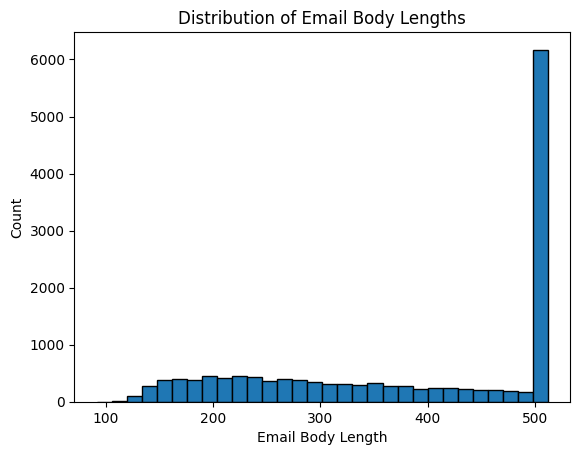

In [ ]:
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df' and the email bodies are stored in the 'Body' column
body_lengths = df['Body'].apply(len)

# Plotting the histogram
plt.hist(body_lengths, bins=30, edgecolor='black')
plt.xlabel('Email Body Length')
plt.ylabel('Count')
plt.title('Distribution of Email Body Lengths')
plt.show()


In [ ]:
df["Prompt"] = "Email: " + df["Body"] + " Subject: " + df["Subject"]

In [ ]:
df.head()

,Body,Subject,Prompt
0,Dad: The name I have is Dr. Vinberg.\nHe is a...,Facilitator,Email: Dad: The name I have is Dr. Vinberg.\n...
1,Hey Jeff - I'm still wondering if my last emai...,some mail,Email: Hey Jeff - I'm still wondering if my la...
2,Thanks for dealing with Tana on these issues.\...,EnronOnline access to Australian Power products,Email: Thanks for dealing with Tana on these i...
3,Attached is the language we are proposing to D...,Draft Dynegy Release,Email: Attached is the language we are proposi...
4,"Sharon, Attached is an Excel file containing ...",Mariner Energy,"Email: Sharon, Attached is an Excel file cont..."


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_0, *['Body'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_1, *['Subject'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_2, *['Prompt'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_3, *['Body', 'Subject'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_4, *['Subject', 'Prompt'], **{})
chart

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# Create an empty DataFrame to store the results
df_dev = pd.DataFrame(columns=['Body', 'Subject', 'Annotation0', 'Annotation1', 'Annotation2'])
folder_path = '/content/AESLC-master/AESLC-master/enron_subject_line/dev/'
# Iterate over the files
file_paths = glob.glob(folder_path + '*.subject')  # Replace '/path/to/files/' with the actual path to your files
for file_path in file_paths:
    with open(file_path, 'r') as file:
        text = file.read()

        # Extract the text above the @subject marker
        body_text = re.search(r'^(.*?)(?=\s*@subject)', text, re.DOTALL).group(1).strip()

        subject = re.search(r'@subject\s+([^@]+)', text, re.DOTALL).group(1).strip()

        ann0_match = re.search(r'@ann0\s(.+?)\n\n', text)
        ann0 = ann0_match.group(1).strip() if ann0_match else None

        ann1_match = re.search(r'@ann1\s(.+?)\n\n', text)
        ann1 = ann1_match.group(1).strip() if ann1_match else None

        ann2_match = re.search(r'@ann2\s(.+)', text)
        ann2 = ann2_match.group(1).strip() if ann2_match else None

        # Append the body text to the DataFrame
        df_dev = pd.concat([df_dev, pd.DataFrame({'Body': [body_text], 'Subject': [subject], 'Annotation0' : [ann0], 'Annotation1' : [ann1] , 'Annotation2' : [ann2]})], ignore_index=True)


# Output the first few rows of the DataFrame
df_dev.head()

,Body,Subject,Annotation0,Annotation1,Annotation2
0,We have some small annoying park & loan deals ...,Iroq Park & Loan,issues with the new deal (heads up),july deal info,park & loan deals
1,What's going on Tree?\nBruce forwarded me your...,What's Up,meeting invitation,"my man, tree! what's up?",want to get a few beers this weekend?
2,"When: Tuesday, May 22, 2001 12:00 PM-2:00 PM (...",Unify Gas Performance Test,may 22 testing schedule,testing schedule,schedule for performance testing on tuesday
3,Bill: For yet another day we seem to be havin...,EPE Schedules for Saturday 02/02/02,problems including schedules in epe,epe schedule sheet issues,epe problem troubleshooting
4,Cinergy going into summer long on power Ciner...,Here's what you're missing...,cinergy summer long,cinergy ceo's views on electricity prices this...,new low summer prices


In [ ]:
max_length = 650

df_dev['Body'] = df_dev['Body'].apply(lambda x: x[:max_length] if len(x) > max_length else x)

In [ ]:
df_dev.describe()

,Body,Subject,Annotation0,Annotation1,Annotation2
count,1960,1960,1960,1960,1960
unique,1815,1785,1935,1940,1946
top,Attached is a revised Credit Watch listing for...,Credit Watch List--Week of 10/29/01,excel document -outages,scheduled power outages,attached: outage information
freq,7,7,6,6,3


In [ ]:
df_dev["Prompt"] = "Email: " + df_dev["Body"] + " Subject: "

In [ ]:
# Define the dev_references
dev_references = []

# Iterate over the rows in the Dev DataFrame
for _, row in df_dev.iterrows():
    references = []
    if row["Annotation0"]:
        references.append(row["Annotation0"])
    if row["Annotation1"]:
        references.append(row["Annotation1"])
    if row["Annotation2"]:
        references.append(row["Annotation2"])

    if len(references) == 0:
        continue
    # Append the references to the dev_references list
    dev_references.append(references)


In [ ]:
dev_references[0], len(dev_references)

(['issues with the new deal (heads up)',
  'july deal info',
  'park & loan deals'],
 1960)

**Model**

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

**PreProcessing of the Data**

In [ ]:
# ----- 1. Preprocess data -----#
# Preprocess data
X = list(df["Prompt"])
X_eval =  list(df_dev["Prompt"])

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
X_train_tokenized = tokenizer(X, padding=True, truncation=True, max_length=728)
X_eval_tokenized = tokenizer(X_eval, padding=True, truncation=True, max_length=728)

In [ ]:
len(df_dev['Prompt'][1])

327

In [ ]:
class EmailSubjectDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings


    def __getitem__(self, idx):
        X_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        X_item["labels"] = X_item["input_ids"]
        return X_item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Create the dataset
train_dataset = EmailSubjectDataset(X_train_tokenized)
eval_datset = EmailSubjectDataset(X_eval_tokenized)
# Example usage of the dataset
sample = train_dataset[0]
print(sample)


{'input_ids': tensor([15333,    25, 17415,    25,   220,   383,  1438,   314,   423,   318,
         1583,    13, 11820,  3900,    13,   198,  1544,   318,   257, 24636,
          287,  6995,   290,   318,   287,   465,   220,  4019,    82,    13,
          198,    40,  6619,   284,   683,  1909,   290,   314,  1807,   339,
         3947,   922,    13,   198,  1544,  7151,   220,   326,   356,  1826,
          329,   734,  2250,   319,   530,  1110,   290,  7269,   617,   640,
          262,  1306,  1110,   611,   220,   340,   318, 12973,    13,   198,
         6653,  1271,   318,   767,  1485,    12,    21,  1828,    12,  1415,
         3901,    13,   198,  1544,  4530,   720,  8628,   583,  1711,   290,
          220,   314,   481,  2298,   326,   510,   355,   345,   561,   307,
          753, 14924,  9307,   284,  1282,   284,  6995,    13,   198, 23318,
          683,   257,   869,   290,   766,   611,   339,   318, 10909,   284,
          345,    13,   198,  1532,   339,   318, 

**Fine-tune pretrained model**

In [ ]:
bleu = evaluate.load('bleu')
rouge = evaluate.load('rouge')
#meteor = evaluate.load('meteor')

In [ ]:
def compute_metrics(pred, references):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions[0]
    logits, labels = pred
    preds = logits[0]
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    new_decoded_pred = modelGenerate(decoded_labels)
    print("Length of new_decoded_pred " , len(new_decoded_pred))
    print("Length of references " , len(references))
    print("First element of new_decoded_pred " ,new_decoded_pred[0])
    print("First element of label " ,decoded_labels[0])
    print("---------------------------")
    print("Second element of new_decoded_pred " ,new_decoded_pred[1])
    print("Second element of label " ,decoded_labels[1])
    """
    rouge_scores = {"rouge-1": [], "rouge-2": [], "rouge-l": []}
    bleu_scores = []

    for pred, refs in zip(new_decoded_pred, references):
        # Compute ROUGE scores
        rouge_scores_per_ref = {"rouge-1": [], "rouge-2": [], "rouge-l": []}
        for ref in refs:
            scores = rouge_scorer.score(pred, ref)
            rouge_scores_per_ref["rouge-1"].append(scores["rouge1"].fmeasure)
            rouge_scores_per_ref["rouge-2"].append(scores["rouge2"].fmeasure)
            rouge_scores_per_ref["rouge-l"].append(scores["rougeL"].fmeasure)

        # Compute BLEU score
        pred_tokens = pred.split()
        ref_tokens = [ref.split() for ref in refs]
        bleu_score = corpus_bleu([ref_tokens], [pred_tokens])

        # Append scores to lists
        rouge_scores["rouge-1"].append(np.mean(rouge_scores_per_ref["rouge-1"]))
        rouge_scores["rouge-2"].append(np.mean(rouge_scores_per_ref["rouge-2"]))
        rouge_scores["rouge-l"].append(np.mean(rouge_scores_per_ref["rouge-l"]))
        bleu_scores.append(bleu_score)

    # Calculate average scores
    avg_rouge_scores = {
        "rouge-1": np.mean(rouge_scores["rouge-1"]),
        "rouge-2": np.mean(rouge_scores["rouge-2"]),
        "rouge-l": np.mean(rouge_scores["rouge-l"]),
    }
    avg_bleu_score = np.mean(bleu_scores)

    return {
        "rouge": avg_rouge_scores,
        "bleu": avg_bleu_score
    }
    """
    bleu_score = bleu.compute(predictions=new_decoded_pred, references=references)
    rouge_score = rouge.compute(predictions=new_decoded_pred, references=references)
    #meteor_score = meteor.compute(predictions=new_decoded_pred, references=references)'METEOR': round(meteor_score['meteor'], 4) * 100

    return {
        'BLEU': round(bleu_score['bleu'], 4) * 100,
        'R1': round(rouge_score['rouge1'], 4) * 100,
        'R2': round(rouge_score['rouge2'], 4) * 100,
        'RL': round(rouge_score['rougeL'], 4) * 100,
        'RLsum': round(rouge_score['rougeLsum'], 4) * 100
    }

def modelGenerate(decodedLabels):
    EVAL_BATCH_SIZE = 4
    tokenizer.padding_side='left'
    model_generated_labels = []
    print("Generation Started for : ", len(decodedLabels))
    n_batches = math.ceil(len(decodedLabels)*1.0 / EVAL_BATCH_SIZE)
    for i in range(n_batches):
        prompts_batch = decodedLabels[i*EVAL_BATCH_SIZE : (i+1)*EVAL_BATCH_SIZE]
        prompts_batch_ids = tokenizer(prompts_batch,
            padding=True, truncation=True, return_tensors='pt').to('cuda')
        output_ids = model.generate(
            input_ids=prompts_batch_ids.input_ids,attention_mask=prompts_batch_ids.attention_mask, max_new_tokens=10,
            pad_token_id=tokenizer.pad_token_id)
        try:
            outputs_batch = [seq.split('Subject:')[1] for seq in
            tokenizer.batch_decode(output_ids, skip_special_tokens=True)]
            model_generated_labels.extend(outputs_batch)
        except IndexError:
            continue

    tokenizer.padding_side='right'
    print(len(model_generated_labels))
    return model_generated_labels

def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak.
    This is a workaround to avoid storing too many tensors that are not needed.
    """
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

# Define Trainer parameters
args = TrainingArguments(
    output_dir="output",
    learning_rate=1e-5,
    evaluation_strategy="epoch",
    eval_steps=500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    seed=0,
)
#rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Define Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_datset,
    compute_metrics=lambda pred: compute_metrics(pred, dev_references),
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,

)

# Train pre-trained model
model.resize_token_embeddings(len(tokenizer))
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu,R1,R2,Rl,Rlsum
1,0.695800,0.601946,2.740000,42.210000,25.770000,41.370000,41.390000
2,0.669700,0.592211,3.090000,43.480000,26.000000,42.690000,42.730000
3,0.670300,0.590356,3.180000,43.730000,26.270000,42.960000,43.000000


Generation Started for :  1960
1960
Length of new_decoded_pred  1960
Length of references  1960
First element of new_decoded_pred    Iroq   
First element of label  Email: We have some small annoying park & loan deals on Iroq for July.
The parking  deal is 323553 and the loan deal is 323558.
When we get cut by an upstream  or downstream pipeline, Iroq uses the park & loan contract to balance the  supplies and markets. Subject: 
---------------------------
Second element of new_decoded_pred    Tree
Second element of label  Email: What's going on Tree?
Bruce forwarded me your email address, probably  against your wishes.
Just thought I'd drop a line and see if your up for  beers sometime this weekend.
I know its tough to fit anytime in between  those dates with the lovely fake breasted super models, but let's try and  hook up sometime. Subject: 
Generation Started for :  1960
1960
Length of new_decoded_pred  1960
Length of references  1960
First element of new_decoded_pred    Iroq 
First

TrainOutput(global_step=10827, training_loss=0.7238298900417864, metrics={'train_runtime': 8244.3966, 'train_samples_per_second': 5.253, 'train_steps_per_second': 1.313, 'total_flos': 1.1514950005248e+16, 'train_loss': 0.7238298900417864, 'epoch': 3.0})

TEST

In [ ]:
# Create an empty DataFrame to store the results
df_test = pd.DataFrame(columns=['Body', 'Subject', 'Annotation0', 'Annotation1', 'Annotation2'])
folder_path = '/content/AESLC-master/AESLC-master/enron_subject_line/test/'
# Iterate over the files
file_paths = glob.glob(folder_path + '*.subject')  # Replace '/path/to/files/' with the actual path to your files
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

        # Extract the text above the @subject marker
        body_text = re.search(r'^(.*?)(?=\s*@subject)', text, re.DOTALL).group(1).strip()

        subject = re.search(r'@subject\s+([^@]+)', text, re.DOTALL).group(1).strip()

        ann0_match = re.search(r'@ann0\s(.+?)\n\n', text)
        ann0 = ann0_match.group(1).strip() if ann0_match else None

        ann1_match = re.search(r'@ann1\s(.+?)\n\n', text)
        ann1 = ann1_match.group(1).strip() if ann1_match else None

        ann2_match = re.search(r'@ann2\s(.+)', text)
        ann2 = ann2_match.group(1).strip() if ann2_match else None

        # Append the body text to the DataFrame
        df_test = pd.concat([df_test, pd.DataFrame({'Body': [body_text], 'Subject': [subject], 'Annotation0' : [ann0], 'Annotation1' : [ann1] , 'Annotation2' : [ann2]})], ignore_index=True)


# Output the first few rows of the DataFrame
df_test.head()

,Body,Subject,Annotation0,Annotation1,Annotation2
0,You are hereby notified that the meeting of th...,Please Read!,check your calendar: federal credit union boar...,board of directors meeting,enron board of directors meeting: 11/19/01 5:...
1,Just working on a Courtney deal while thoughts...,Deep Thoughts,thinking of you,thinking of you,lucky to be with you
2,Attached is that RUSH guaranty Stuart Zisman c...,RUSH GUARANTY,please sign!,signatures needed today,urgent--guaranty and certificate need signatures
3,We are currently upgrading out networks at thi...,The Prometheus File - Energy Technology Weekly...,upgrading out networks,network upgrades/news highlights,network upgrades
4,Following are the deal numbers for interdesk s...,Interdesk swaps - 4/23 and 4/24,deal numbers for interdesk swaps stca/stwbom,please review these interdesk swap deal number...,deal numbers for interdesk swaps


In [ ]:
df_test["Prompt"] = "Email: " + df_test["Body"] + " Subject: "

In [ ]:
df_test['Body'][0]

'You are hereby notified that the meeting of the Board of Directors of Enron Federal Credit Union will be held on Monday, November 19th, 2001 at 5:00 P.M.  Conference Room EB/ECN 49c3, 1400 Smith Street, has been reserved for your use.\nWe would appreciate your support in making our meetings as efficient and as productive as they can be.\nIf you will not be attending; or  \tIf you will not be able to arrive at the start of the meeting at 5:00 p.m.; or  \tIf you would like to join the meeting by conference call,  Please RSVP to Jennifer Jordan by, returning an email or by phone.\nPlease note: If you would like to invite a guest to the board meeting, please notify Jack McAdoo at x3-6249 prior to the meeting for the schedule considerations.\nThank you,'

In [ ]:
# Define the dev_references
test_references = []

# Iterate over the rows in the Dev DataFrame
for _, row in df_test.iterrows():
    references = []
    if row["Annotation0"]:
        references.append(row["Annotation0"])
    if row["Annotation1"]:
        references.append(row["Annotation1"])
    if row["Annotation2"]:
        references.append(row["Annotation2"])

    if len(references) == 0:
        continue
    # Append the references to the dev_references list
    test_references.append(references)


In [ ]:
test_references[0], len(test_references)

(['check your calendar: federal credit union board of directors meeting on 11/19',
  'board of directors meeting',
  'enron board of directors meeting:  11/19/01 5:00 pm'],
 1906)

In [ ]:
# Define your input prompt
prompt = "Email: You are hereby notified that the meeting of the Board of Directors of Enron Federal Credit Union will be held on Monday, November 19th, 2001 at 5:00 P.M.  Conference Room EB/ECN 49c3, 1400 Smith Street, has been reserved for your use. We would appreciate your support in making our meetings as efficient and as productive as they can be.If you will not be attending; or  	If you will not be able to arrive at the start of the meeting at 5:00 p.m.; or  	If you would like to join the meeting by conference call,  Please RSVP to Jennifer Jordan by, returning an email or by phone.Please note: If you would like to invite a guest to the board meeting, please notify Jack McAdoo at x3-6249 prior to the meeting for the schedule considerations.Thank you,"

# Tokenize the input text
input_ids = tokenizer.encode(prompt, return_tensors="pt").to('cuda')

# Generate text using the model
output = model.generate(input_ids, max_length=728, max_new_tokens=10,pad_token_id=tokenizer.pad_token_id)

# Decode the generated token IDs back to text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Print the generated text
print(generated_text)